# Perturbations
Implementation of a Python simulation of a quantum system of 2 spins coupled to a phonon degree of freedom. The aim is to reproduce exactly the time evolution given by the Mølmer-Sørensen interaction, and then to test and apply different perturbative expansions such as the Magnus expansion, the Dyson series, the Schrieffer-Wolff transformation and the high frequency expansion.

The Mølmer-Sørensen Hamiltonian for 2 atoms (spins) coupled to a vibrational state (with truncated single occupancy) can be expressed in the following form:

$$
H_{MS} = \eta \frac{\hbar \Omega}{2} \left( \sigma_x^{(1)}+ \sigma_x^{(2)}\right)\left( a^\dagger e^{-i\delta t} + a e^{i \delta t}\right)
$$

where $\eta$ is the Lamb-Dicke parameter, $\Omega$ the frequency corresponding to the energy difference between the two atomic levels and $a$ and $a^\dagger$ the ladder operators for the number of phonons.

In [1]:
# Import libraries

import math
import numpy as np
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.legend_handler import HandlerTuple
from matplotlib.ticker import FormatStrFormatter
from matplotlib import rc
from scipy.optimize import curve_fit
from scipy import linalg
import re
import scipy.integrate as integrate
import scipy.linalg as sla
pi = math.pi


In [2]:
# Pauli x matrix
sgm_x = np.array([[0.,1.],[1.,0.]])
# Pauli y matrix
sgm_y = np.array([[0.,-1j],[1j,0.]])
#Pauli z matrix
sgm_z = np.array([[1.,0.],[0.,-1.]])
# 2x2 identity
id_2 = np.eye(2)
# Ladder operators for phonon number
a_dagger = np.array([[0.,1.],[0.,0.]])
a = np.array([[0.,0.],[1.,0.]])

# state at time t
state = np.zeros(shape=(8,1))
# Define ground state
s_1 = np.array([[0.],[1.]])
s_2 = np.array([[0.],[1.]])
vib = np.array([[0.],[1.]])
gs = np.kron(s_1, np.kron(s_2, vib))

# Interaction Hamiltonian
def H_1(t, freq_ratio, delta):
    return 0.5*freq_ratio*delta*np.kron(np.kron(sgm_x,id_2) + np.kron(id_2,sgm_x), a_dagger*np.exp(-1j*delta*t) + a*np.exp(1j*delta*t))

# Displacement operator 
def D(x):
    return linalg.expm(np.kron(x, a_dagger)- np.kron(x.conj().T, a))
# Function of t
def alpha(t,freq_ratio, delta):
    return 0.5j*freq_ratio*(1- np.exp(1j*delta*t))
# Function of t
def Phi(t, freq_ratio, delta):
    return (0.25*freq_ratio**2)*(delta*t - np.sin(delta*t))
# Sum of Pauli x matrices acting on the 2 spins
def S_x():
    return np.kron(sgm_x, id_2) + np.kron(id_2, sgm_x) 

# Exact time evolution operator (Hempel) == 2nd order Magnus
def U(t, freq_ratio,delta):
    A = alpha(t,freq_ratio,delta)*S_x()
    d = D(A)
    C = linalg.expm(1j*Phi(t, freq_ratio,delta)*np.kron(S_x() @ S_x(), id_2))
    U = d @ C
    return U

# First Magnus term (time integral of H_1)
def M1(t, freq_ratio, delta):
        return -1j*(freq_ratio)*np.sin(0.5*delta*t)*np.kron(S_x(), \
        np.exp(0.5j*delta*t)*a + np.exp(-0.5j*delta*t)*a_dagger)
# Second Magnus term (double time integral of [H_1(t1),H_1(t2)])
def M2(t, freq_ratio, delta):
        return -0.5j*(freq_ratio**2)*delta*(t - np.sin(delta*t)/delta)*np.kron( np.kron(sgm_x, sgm_x), id_2)
# Slow gate Ising coupling
def H_ising(freq_ratio, delta):
     return -0.5*(freq_ratio**2)*delta*np.kron( np.kron(sgm_x, sgm_x), id_2)
# Time evolution given by HFE
def U_hfe(t, freq_ratio, delta):

    # e^(-i delta t) harmonic
    H_fourier_m1 = 0.5*freq_ratio*delta*np.kron(np.kron(sgm_x,id_2) + np.kron(id_2,sgm_x), a_dagger)
    # e^(i delta t) harmonic
    H_fourier_1 = 0.5*freq_ratio*delta*np.kron(np.kron(sgm_x,id_2) + np.kron(id_2,sgm_x), a)

    # Effective Hamiltonian HFE, time average is zero so H_eff_0 = 0
    H_eff_1 = (H_fourier_1 @ H_fourier_m1 - H_fourier_m1 @ H_fourier_1)/delta

    # Kick operator at 1st order
    G1 = -(1/delta)*(H_fourier_1*np.exp(1j*delta*t) - H_fourier_m1*np.exp(-1j*delta*t))
    #G2 = (1/(4*delta*delta))*(np.exp(-2j*delta*t) * (H_fourier_m1 @ H_fourier_1 - H_fourier_1 @ H_fourier_m1)+\
    #                          np.exp(2j*delta*t)*(H_fourier_1 @ H_fourier_m1 - H_fourier_m1 @ H_fourier_1))
    return linalg.expm(G1) @ linalg.expm(-1j*t*H_eff_1) @ linalg.expm(-G1)


# Expectation values of Pauli z
def expectation_z1(state):
    return float(np.real(state.conj().T @ np.kron(np.kron(sgm_z, id_2),id_2) @ state))
def expectation_z2(state):
    return float(np.real(state.conj().T @ np.kron(np.kron(id_2, sgm_z),id_2) @ state))
def expectation_z(state):
    return 0.5*expectation_z1(state) + 0.5*expectation_z2(state)


First simulation of level populations as a function of time. The time evolution operator is computed exactly.

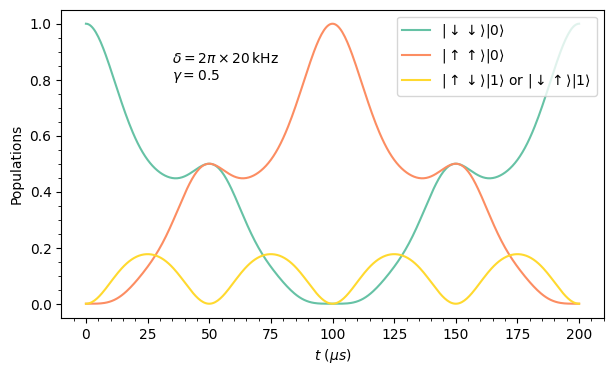

In [3]:
############## PARAMETERS ##############
# Frequencies ratio gamma = Omega/delta
freq_ratio = 0.5
# Detune frequency
delta = 2*pi*0.02 # 2pi x MHz
# time step
dt = .5 # micro s
# final time
t_fin = 200 # micro s
########################################
# number of time steps
t_steps = t_fin/dt
# time vector
t= np.arange(0, t_fin + dt, dt)

# Populations
pop00 = []
pop11 = []
pop10 = []
pop1001_excited = []
# Compute state at time t and calculate probability amplitude
for kk in np.arange(0, int(t_steps)+1, 1):
    
    state = linalg.expm( M1(t[kk], freq_ratio, delta) +  M2(t[kk], freq_ratio, delta) ) @ gs
    #state = U(t[kk], freq_ratio, delta) @ gs
    pop00.append(np.abs(state[7])**2)
    pop11.append(np.abs(state[1]**2))
    pop1001_excited.append(0.5*np.abs(state[2])**2 + 0.5*np.abs(state[4])**2)

# Plot of populations
cmap = plt.get_cmap('Set2')
w = 7
h = 4
fig = plt.figure(figsize=(w,h))


plt.plot(t,pop00, color = cmap(0), label = '$| \downarrow \downarrow \\rangle | 0\\rangle$')
plt.plot(t,pop11, color = cmap(1), label = '$| \\uparrow \\uparrow \\rangle | 0\\rangle$')
plt.plot(t,pop1001_excited, color = cmap(5), label = '$|\\uparrow \\downarrow \\rangle |   1 \\rangle$ or $|\\downarrow \\uparrow\\rangle |   1 \\rangle$')
#plt.plot(t, sum_pop)
plt.xlabel('$t \,\,(\mu s)$')
plt.ylabel('Populations')
text = '$\delta = 2\pi\\times $' + str(round(1000*delta/(2*pi)))+ '$\,\mathrm{kHz}$\n$\gamma =$'\
        + str(round(freq_ratio,2))
tl = text
#plt.title(tl)
plt.text(35, 0.8,text)
plt.minorticks_on()
plt.legend()
save_fig = True
if save_fig == True:
    plt.savefig("../plots/populations.pdf") 
plt.show()
 

The time evolution of the expectation value $\frac{\langle S_z\rangle}{2}$ is computed exactly and compared with the perturbative time evolution given by Magnus series (both first and second order) and Dyson series (second order). The Ising coupling is also shown.

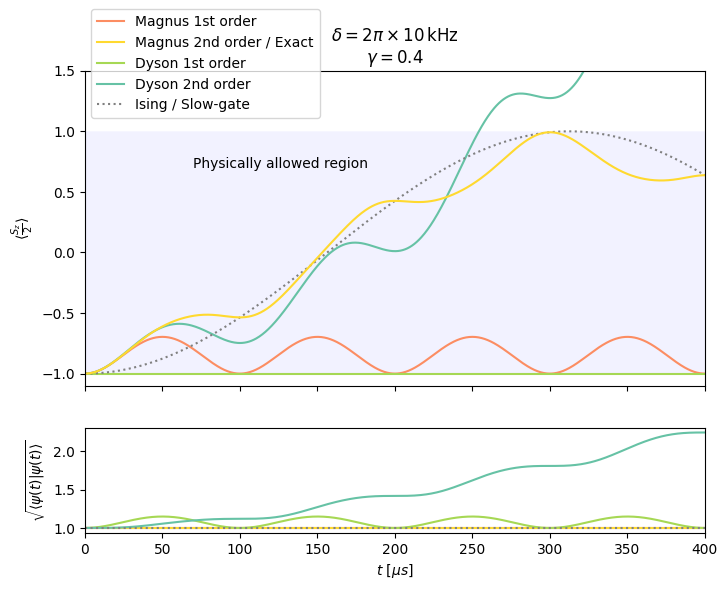

In [186]:
############## PARAMETERS ##############
# Frequencies ratio omega = Omega/delta
freq_ratio = 0.4
delta = 2*pi*0.01
# time step
dt = .5 # micro s
# final time
t_fin = 400 # micro s
########################################
# number of time steps
t_steps = t_fin/dt
# time vector
t= np.arange(0, t_fin + dt, dt)

I = np.kron(np.kron(id_2,id_2),id_2)
D1 = np.zeros(shape = (len(state), len(state)), dtype = complex)

mean_z = []
mean_z1 = []
mean_z2 = []
mean_z1d = []
mean_z2d = []
mean_slow = []
norm_z = []
norm_z1 = []
norm_z2 = []
norm_z1d = []
norm_z2d = []
norm_slow = []

# ... evolve the state with different expansions
for kk in np.arange(0, int(t_steps)+1, 1):
        # Magnus:
        state1 = linalg.expm(M1(t[kk], freq_ratio, delta)) @ gs
        state2 = linalg.expm(M1(t[kk], freq_ratio, delta) + M2(t[kk], freq_ratio, delta)) @ gs
        # Dyson:
        # Remember the relationship between Magnus terms and Dyson terms:  D1 = M1 and D2 = M2 + 0.5 M1^2
        state1d = (I + M1(t[kk], freq_ratio, delta))@ gs
        state2d = (I + M1(t[kk], freq_ratio,delta) + M2(t[kk], freq_ratio,delta) + \
                        0.5*M1(t[kk], freq_ratio,delta) @ M1(t[kk], freq_ratio,delta))@ gs
        # Slow gate Ising coupling
        state_slow = linalg.expm(-1j*t[kk]*H_ising(freq_ratio,delta)) @ gs
        # Store expectation values in a list
        mean_z.append(expectation_z(state))
        mean_z1.append(expectation_z(state1))
        mean_z2.append(expectation_z(state2))
        mean_z1d.append(expectation_z(state1d))
        mean_z2d.append(expectation_z(state2d))
        mean_slow.append(expectation_z(state_slow))

        norm_z.append(linalg.norm(state))
        norm_z1.append( linalg.norm(state1))
        norm_z2.append( linalg.norm(state2))
        norm_z1d.append( linalg.norm(state1d))
        norm_z2d.append( linalg.norm(state2d))
        norm_slow.append( linalg.norm(state_slow))
# Plot of time evolution <S_Z/2>
cmap = plt.get_cmap('Set2')
w = 8
h = 6

tl = '$\delta = 2\pi\\times $' + str(round(1000*delta/(2*pi)))+ '$\,\mathrm{kHz}$\n$\gamma =$'\
        + str(round(freq_ratio,2))


fig, axs = plt.subplots(2, figsize=(w,h), gridspec_kw={'height_ratios': [3,1]},sharex= True)

#axs[0].plot(t, mean_z, color = 'k',label = 'Exact')
axs[0].plot(t, mean_z1,  color = cmap(1), linestyle = 'solid',label = 'Magnus 1st order')
axs[0].plot(t, mean_z1d,  color = cmap(4), linestyle = 'solid',label = 'Dyson 1st order')
axs[0].plot(t, mean_z2d,  color = cmap(0), linestyle = 'solid',label = 'Dyson 2nd order')
axs[0].plot(t, mean_slow,  color = 'gray', linestyle = 'dotted',label = 'Ising - Slow gate')
axs[0].plot(t, mean_z2,  color = cmap(5), linestyle = 'solid',label = 'Magnus 2nd order / Exact')

axs[0].set_xlabel('$t$ [$\mu s$]')
axs[0].set_ylabel('$\\frac{\langle S_z\\rangle}{2}$')
axs[0].fill_between(t, -1,1, facecolor= 'blue', alpha = 0.05)
axs[0].text(70,0.7, 'Physically allowed region')
axs[0].set_xlim(0,400)
axs[0].set_ylim(-1.1, 1.5)
axs[0].set_title(tl)

#axs[1].plot(t, norm_z,  color = 'k', linestyle = 'solid',label = 'Exact')
axs[1].plot(t, norm_z1,  color = cmap(1), linestyle = 'solid',label = 'Magnus 1st order')
axs[1].plot(t, norm_z2,  color = cmap(5), linestyle = 'solid',label = 'Magnus 2nd order / Exact')
axs[1].plot(t, norm_z1d,  color = cmap(4), linestyle = 'solid',label = 'Dyson 1st order')
axs[1].plot(t, norm_z2d,  color = cmap(0), linestyle = 'solid',label = 'Dyson 2nd order')
axs[1].plot(t, norm_slow,  color = 'gray', linestyle = 'dotted',label = 'Ising / Slow-gate')

# Labels setup
axs[0].set(xlabel='$t$ [$\mu s$]', ylabel='$\langle \\frac{S_z}{2}\\rangle}$')
axs[1].set(xlabel='$t$ [$\mu s$]', ylabel='$\sqrt{\\langle \psi(t) | \psi(t)\\rangle }$')
#axs[1].set_ylim(0.8,2.5)
for ax in axs.flat:
    ax.label_outer()
# Legend setup
handles, labels = ax.get_legend_handles_labels()

fig.legend(handles, labels, loc=(0.125,0.8))
save_fig = True
if save_fig == True:
    plt.savefig("../plots/norm.pdf") 
plt.show()

Study of $\langle S_z/2 \rangle$, for a fixed $\delta$ and different $\gamma$ values. Magnus and Dyson expansions (and Ising / slow-gate coupling).

<Figure size 800x1000 with 0 Axes>

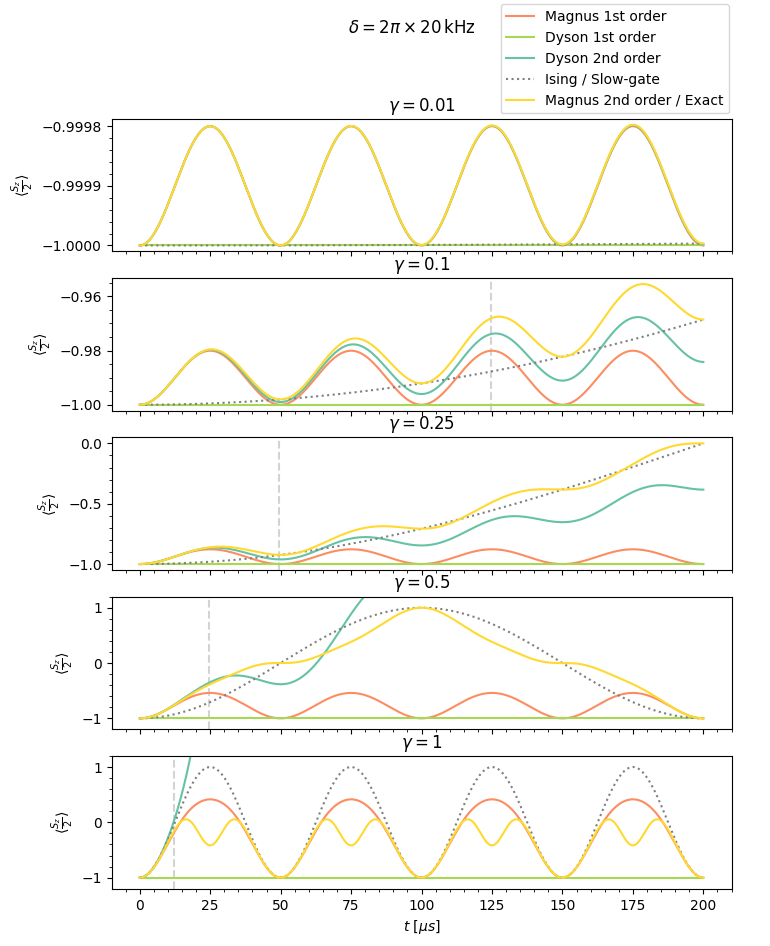

In [171]:
############## PARAMETERS ##############
# Frequencies ratio gamma = Omega/delta
freq_ratio = [0.01, 0.1, 0.25, 0.5, 1]
delta = 2*pi*0.02
# time step
dt = .5 # micro s
# final time
t_fin = 200 # micro s
########################################



# number of time steps
t_steps = t_fin/dt
# time vector
t= np.arange(0, t_fin + dt, dt)

# Unitary rotation
def R(t, delta):
    return linalg.expm(0.5j*delta*t*np.kron(np.kron(id_2, id_2), sgm_z) )

# rotated Hamiltonian
def H_rotated(freq_ratio,delta):
    return 0.5*freq_ratio*delta*np.kron(np.kron(sgm_x,id_2) + np.kron(id_2,sgm_x), \
                    a_dagger + a) - 0.5*delta*np.kron(np.kron(id_2, id_2), sgm_z)

# Prepare plot of mean <sgm_z> as a function of t, for different frequency ratios
cmap = plt.get_cmap('Set2')
w = 8
h = 10
fig = plt.figure(figsize=(w,h))
tl = '$\delta = 2\pi\\times $' + str(round(1000*delta/(2*pi)))+ '$\,\mathrm{kHz}$'

fig, axs = plt.subplots(len(freq_ratio), figsize= (w,h),sharex= True)
fig.suptitle(tl)
# Mean z values
I = np.kron(np.kron(id_2,id_2),id_2)
D1 = np.zeros(shape = (len(state), len(state)), dtype = complex)
# For each  ratio ...
for jj in range(0, len(freq_ratio)):
    mean_z = []
    mean_z1 = []
    mean_z2 = []
    mean_z1d = []
    mean_z2d = [] 
    mean_swt = []
    mean_ising = []
    # ... evolve the state with different expansions
    for kk in np.arange(0, int(t_steps)+1, 1):
        
        # Calculate the integral of the norm of H and check when it is greater
        # pi (theoretical bound)
        res, err = integrate.quad( lambda t: linalg.norm(H_1(t, freq_ratio[jj], delta)), 0, t[kk])
        if( res < pi):
            t_limit = t[kk]

        # Exact:
        state = U(t[kk], freq_ratio[jj], delta) @ gs
        # Ising coupling
        state_ising = linalg.expm(-1j*t[kk]*H_ising(freq_ratio[jj],delta)) @ gs
        # Magnus:
        state1 = linalg.expm(M1(t[kk], freq_ratio[jj], delta)) @ gs
        state2 = linalg.expm(M1(t[kk], freq_ratio[jj], delta) + M2(t[kk], freq_ratio[jj], delta)) @ gs
        # Dyson:
        # Remember the relationship between Magnus terms and Dyson terms:  D1 = M1 and D2 = M2 + 0.5 M1^2
        state1d = (I + M1(t[kk], freq_ratio[jj], delta))@ gs
        state2d = (I + M1(t[kk], freq_ratio[jj],delta) + M2(t[kk], freq_ratio[jj],delta) + \
                 0.5*M1(t[kk], freq_ratio[jj],delta) @ M1(t[kk], freq_ratio[jj],delta))@ gs 
        stateswt =  linalg.expm(-1j*t[kk]*H_rotated(freq_ratio[jj], delta)) @ (R(t[kk],delta)@ gs)
        # Store expectation values in a list
        mean_z.append(expectation_z(state))
        mean_z1.append(expectation_z(state1))
        mean_z2.append(expectation_z(state2))
        mean_z1d.append(expectation_z(state1d))
        mean_z2d.append(expectation_z(state2d))
        mean_swt.append(expectation_z(stateswt))
        mean_ising.append(expectation_z(state_ising))
    # Plot the different time evolutions for jj-th ratio value
    #axs[jj].plot(t, mean_z, color = 'k',label = 'Exact')
    if(t[kk] != t_limit):
        axs[jj].axvline(t_limit, linestyle= 'dashed', color = 'lightgray')
    axs[jj].plot(t, mean_z1,  color = cmap(1), linestyle = 'solid',label = 'Magnus 1st order')
    axs[jj].plot(t, mean_z1d,  color = cmap(4), linestyle = 'solid',label = 'Dyson 1st order')
    axs[jj].plot(t, mean_z2d,  color = cmap(0), linestyle = 'solid',label = 'Dyson 2nd order')
    axs[jj].plot(t, mean_ising,  color = 'gray', linestyle = 'dotted', label = 'Ising / Slow-gate')
    axs[jj].plot(t, mean_z2,  color = cmap(5), linestyle = 'solid',label = 'Magnus 2nd order / Exact')
    
    axs[jj].minorticks_on()
    axs[jj].set_title('$\gamma=$' + str(freq_ratio[jj]))


# Set a low y limit on the axis for higher ratios since Dyson series diverges

axs[3].set_ylim(-1.2,1.2)
axs[4].set_ylim(-1.2,1.2)
#axs[0].set_xlim(-5,205)
# Labels setup
for ax in axs.flat:
    ax.set(xlabel='$t$ [$\mu s$]', ylabel='$\langle \\frac{S_z}{2}\\rangle}$')
for ax in axs.flat:
    ax.label_outer()
# Legend setup
handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels, loc=(0.65,0.88))
save_fig = True
if save_fig == True:
    plt.savefig("../plots/comparison.pdf") 
plt.show()



Study of $\langle S_z/2 \rangle$, for a fixed $\gamma$ and different $\delta$ values. Magnus and Dyson expansions (and Ising / slow-gate coupling).

<Figure size 800x1000 with 0 Axes>

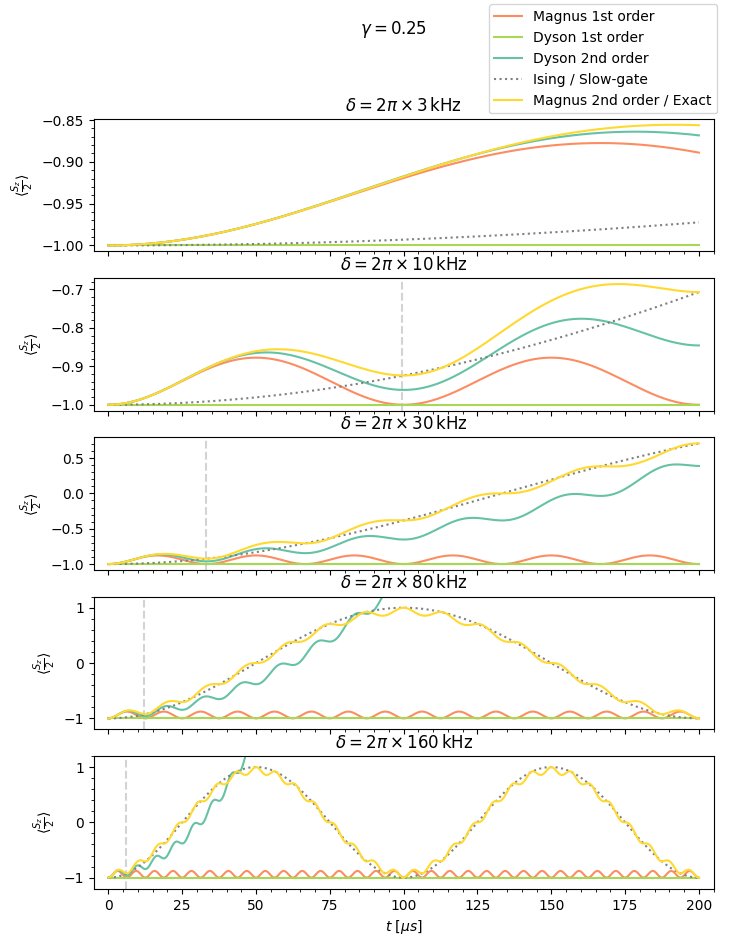

In [172]:
############## PARAMETERS ##############
# delta frequencies
delta = 2*pi*np.array([0.003, 0.01, 0.03, 0.08, 0.16])
# Frequency ratio gamma = Omega/delta
freq_ratio = 0.25*np.ones(len(delta))
# time step
dt = .5 # micro s
# final time
t_fin = 200 # micro 
#########################################

# number of time steps
t_steps = t_fin/dt
# time vector
t= np.arange(0, t_fin + dt, dt)


# Prepare plot of mean <sgm_z> as a function of t, for different delta
cmap = plt.get_cmap('Set2')
w = 8
h = 10
fig = plt.figure(figsize=(w,h))
tl = '$\gamma = $' + str(round(freq_ratio[0], 3))

fig, axs = plt.subplots(len(freq_ratio), figsize= (w,h),sharex= True)
fig.suptitle(tl)
# Mean z values
I = np.kron(np.kron(id_2,id_2),id_2)
D1 = np.zeros(shape = (len(state), len(state)), dtype = complex)
# For each  ratio ...
for jj in range(0, len(freq_ratio)):
    mean_z = []
    mean_z1 = []
    mean_z2 = []
    mean_z1d = []
    mean_z2d = [] 
    mean_swt = []
    mean_ising = []
    # ... evolve the state with different expansions
    for kk in np.arange(0, int(t_steps)+1, 1):
        
        # Calculate the integral of the norm of H and check when it is greater
        # pi (theoretical bound)
        res, err = integrate.quad( lambda t: linalg.norm(H_1(t, freq_ratio[jj], delta[jj])), 0, t[kk])
        if( res < pi):
            t_limit = t[kk]

        # Exact:
        state = U(t[kk], freq_ratio[jj], delta[jj]) @ gs
        # Magnus:
        state1 = linalg.expm(M1(t[kk], freq_ratio[jj], delta[jj])) @ gs
        state2 = linalg.expm(M1(t[kk], freq_ratio[jj], delta[jj]) + M2(t[kk], freq_ratio[jj], delta[jj])) @ gs
        # Dyson:
        # Remember the relationship between Magnus terms and Dyson terms:  D1 = M1 and D2 = M2 + 0.5 M1^2
        state1d = (I + M1(t[kk], freq_ratio[jj], delta[jj]))@ gs
        state2d = (I + M1(t[kk], freq_ratio[jj],delta[jj]) + M2(t[kk], freq_ratio[jj],delta[jj]) + \
                 0.5*M1(t[kk], freq_ratio[jj],delta[jj]) @ M1(t[kk], freq_ratio[jj],delta[jj]))@ gs 
        stateswt =  linalg.expm(-1j*t[kk]*H_rotated(freq_ratio[jj], delta[jj])) @ (R(t[kk],delta[jj])@ gs)
        # Ising coupling
        state_ising = linalg.expm(-1j*t[kk]*H_ising(freq_ratio[jj],delta[jj])) @ gs
        # Store expectation values in a list
        mean_z.append(expectation_z(state))
        mean_z1.append(expectation_z(state1))
        mean_z2.append(expectation_z(state2))
        mean_z1d.append(expectation_z(state1d))
        mean_z2d.append(expectation_z(state2d))
        mean_swt.append(expectation_z(stateswt))
        mean_ising.append(expectation_z(state_ising))
    # Plot the different time evolutions for jj-th ratio value
    #axs[jj].plot(t, mean_z, color = 'k',label = 'Exact')
    if(t[kk] != t_limit):
        axs[jj].axvline(t_limit, linestyle= 'dashed', color = 'lightgray')
    axs[jj].plot(t, mean_z1,  color = cmap(1), linestyle = 'solid',label = 'Magnus 1st order')
    
    axs[jj].plot(t, mean_z1d,  color = cmap(4), linestyle = 'solid',label = 'Dyson 1st order')
    axs[jj].plot(t, mean_z2d,  color = cmap(0), linestyle = 'solid',label = 'Dyson 2nd order')
    axs[jj].plot(t, mean_ising,  color = 'gray', linestyle = 'dotted', label = 'Ising / Slow-gate')
    axs[jj].plot(t, mean_z2,  color = cmap(5), linestyle = 'solid',label = 'Magnus 2nd order / Exact')
    
    axs[jj].minorticks_on()
    axs[jj].set_title('$\delta = 2\pi\\times $' + str(round(1000*delta[jj]/(2*pi)))+ '$\,\mathrm{kHz}$')


# Set a low y limit on the axis for higher ratios since Dyson series diverges
#axs[1].set_ylim(-1.1,-0.6)
#axs[2].set_ylim(-1.2,1.2)
axs[3].set_ylim(-1.2,1.2)
axs[4].set_ylim(-1.2,1.2)
axs[0].set_xlim(-5,205)
# Labels setup
for ax in axs.flat:
    ax.set(xlabel='$t$ [$\mu s$]', ylabel='$\langle \\frac{S_z}{2}\\rangle}$')
for ax in axs.flat:
    ax.label_outer()
# Legend setup
handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels, loc=(0.65,0.88))
save_fig = True
if save_fig == True:
    plt.savefig("../plots/comparison2.pdf") 
plt.show()



Study of $\langle S_z/2 \rangle$, for a fixed $\gamma$ and different $\delta$ values. High frequency and Schrieffer-Wolff expansions (and Ising / slow-gate coupling).

<Figure size 800x1000 with 0 Axes>

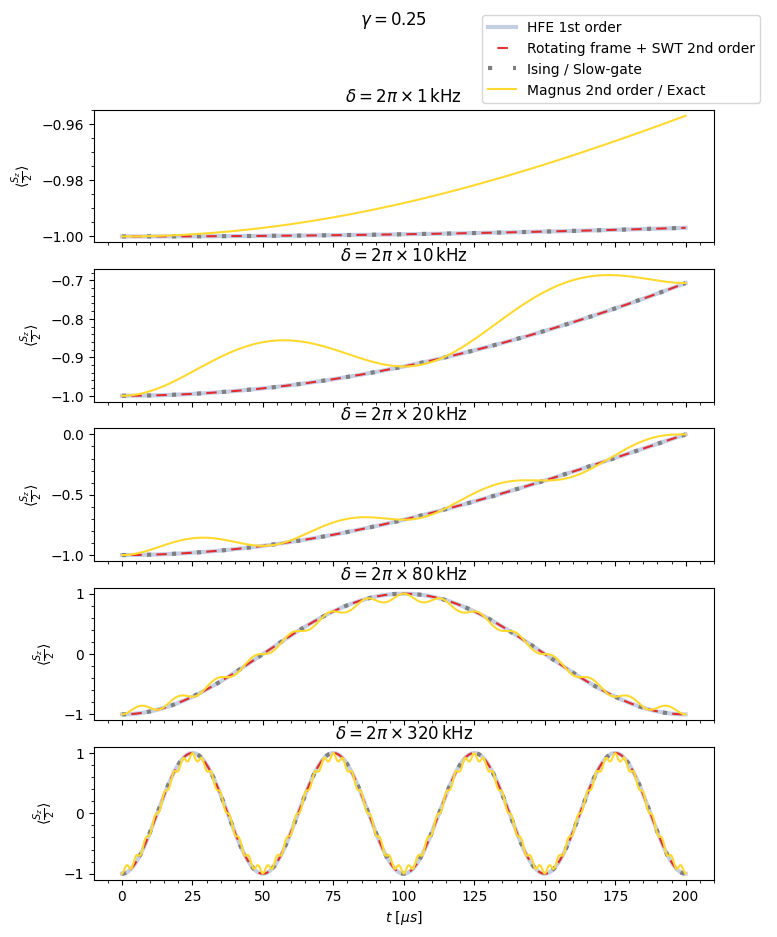

In [173]:
############## PARAMETERS ##############
# delta frequencies
delta = 2*pi*np.array([0.001, 0.01, 0.02, 0.08, 0.320])
# Frequency ratio gamma = Omega/delta
freq_ratio = 0.25*np.ones(len(delta))
# time step
dt = .5 # micro s
# final time
t_fin = 200 # micro s
########################################

# number of time steps
t_steps = t_fin/dt
# time vector
t= np.arange(0, t_fin + dt, dt)




# Prepare plot of mean <sgm_z> as a function of t, for different frequency ratios
cmap = plt.get_cmap('Set2')
cmap2 = plt.get_cmap('Set1')
w = 8
h = 10
fig = plt.figure(figsize=(w,h))
tl = '$\gamma = $' + str(round(freq_ratio[0], 3))

fig, axs = plt.subplots(len(freq_ratio), figsize= (w,h),sharex= True)
fig.suptitle(tl)
# Mean z values
I = np.kron(np.kron(id_2,id_2),id_2)
D1 = np.zeros(shape = (len(state), len(state)), dtype = complex)
# For each  ratio ...
for jj in range(0, len(freq_ratio)):
    mean_z = []
    mean_z1 = []
    mean_z2 = []
    mean_z1d = []
    mean_z2d = [] 
    mean_swt = []
    mean_hfe = []
    mean_ising = []
    # Decompose H as H0 + V
    V = np.array(0.5*freq_ratio[jj]*delta[jj]*np.kron(np.kron(sgm_x,id_2) + np.kron(id_2,sgm_x), a_dagger + a))
    
    H0 = np.array( np.kron(np.kron(id_2, id_2), -0.5*delta[jj]*sgm_z))

    # Solve eigenvalue problem for H0
    evalues, evectors = sla.eig(H0)
    evalues = np.array(np.real(evalues))
    evectors = np.array(evectors)
    
    # Construct generator of SWT rotation
    S = np.zeros(shape=(len(H0),len(H0)))
    for k in range(0,len(evectors)):
        for j in range(0,len(evectors)):
            if(evalues[k] != evalues[j]):
                S[k][j] = ( evectors[:, k].conj().T @ V @ evectors[:, j] ) / (evalues[k] - evalues[j])

    # SWT effective Hamiltonian at 2nd order
    H_eff = H0 +  0.5*(S @ V - V @ S) 

    # ... evolve the state with different expansions
    for kk in np.arange(0, int(t_steps)+1, 1):

        # Magnus:
        state2 = linalg.expm(M1(t[kk], freq_ratio[jj], delta[jj]) + M2(t[kk], freq_ratio[jj], delta[jj])) @ gs
        # Dyson:
        state2d = (I + M1(t[kk], freq_ratio[jj],delta[jj]) + M2(t[kk], freq_ratio[jj],delta[jj]) + \
                 0.5*M1(t[kk], freq_ratio[jj],delta[jj]) @ M1(t[kk], freq_ratio[jj],delta[jj]))@ gs 
        # SWT:
        stateswt =  linalg.expm(-1j*t[kk]*H_eff) @ gs
        # HFE
        state_hfe = U_hfe(t[kk], freq_ratio[jj], delta[jj]) @ gs
        # Ising coupling
        state_ising = linalg.expm(-1j*t[kk]*H_ising(freq_ratio[jj],delta[jj])) @ gs
        # Store expectation values in a list
        mean_z2.append(expectation_z(state2))
        mean_z2d.append(expectation_z(state2d))
        mean_swt.append(expectation_z(stateswt))
        mean_hfe.append(expectation_z(state_hfe))
        mean_ising.append(expectation_z(state_ising))

    # Plot the different time evolutions for jj-th ratio value
    axs[jj].plot(t, mean_hfe,  color = cmap(2), linestyle = 'solid', linewidth = 3, alpha = 0.5 ,label = 'HFE 1st order')
    axs[jj].plot(t, mean_swt,  color = cmap2(0), linestyle =(7.5,(5,7)), linewidth = 1.5, alpha = 0.9, label = 'Rotating frame + SWT 2nd order')
    axs[jj].plot(t, mean_ising,  color = 'gray', linestyle = (0,(1,5)), linewidth = 3   ,label = 'Ising / Slow-gate')
    axs[jj].plot(t, mean_z2,  color = cmap(5), linestyle = 'solid',label = 'Magnus 2nd order / Exact')
    axs[jj].minorticks_on()
    axs[jj].set_title('$\delta = 2\pi\\times $' + str(round(1000*delta[jj]/(2*pi)))+ '$\,\mathrm{kHz}$')



# Labels setup
for ax in axs.flat:
    ax.set(xlabel='$t$ [$\mu s$]', ylabel='$\langle \\frac{S_z}{2}\\rangle}$')
for ax in axs.flat:
    ax.label_outer()
# Legend setup
handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels, loc=(0.62,0.89))
save_fig = True
if save_fig == True:
    plt.savefig("../plots/hfe_swt.pdf") 
plt.show()



A final comparison between all perturbative treatments (Magnus, Dyson, HFE, SWT and slow-gate)

<Figure size 800x500 with 0 Axes>

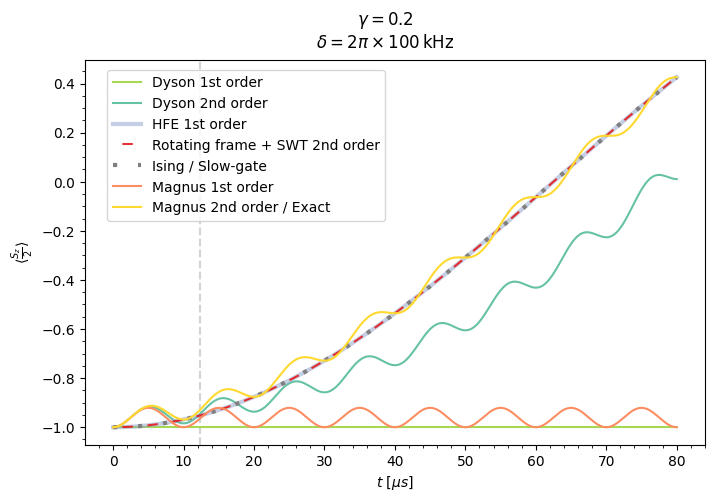

In [174]:
# Frequencies ratio gamma = Omega/delta
delta = 2*pi*np.array([0.10])
freq_ratio = 0.2*np.array([1])
# time step
dt = .1 # micro s
# final time
t_fin = 80 # micro s


# number of time steps
t_steps = t_fin/dt
# time vector
t= np.arange(0, t_fin + dt, dt)


jj = 0

# Prepare plot of mean <sgm_z> as a function of t, for different frequency ratios
cmap = plt.get_cmap('Set2')
w = 8
h = 5
fig = plt.figure(figsize=(w,h))
tl = '$\gamma = $' + str(round(freq_ratio[0], 3)) + '\n$\delta = 2\pi\\times $' + str(round(1000*delta[jj]/(2*pi)))+ '$\,\mathrm{kHz}$'

fig, axs = plt.subplots(len(freq_ratio), figsize= (w,h),sharex= True)
fig.suptitle(tl)
# Mean z values
I = np.kron(np.kron(id_2,id_2),id_2)
D1 = np.zeros(shape = (len(state), len(state)), dtype = complex)


mean_z = []
mean_z1 = []
mean_z2 = []
mean_z1d = []
mean_z2d = [] 
mean_swt = []
mean_hfe = []
mean_ising = []
# Decompose H as H0 + V
V = np.array(0.5*freq_ratio[jj]*delta[jj]*np.kron(np.kron(sgm_x,id_2) + np.kron(id_2,sgm_x), a_dagger + a))

H0 = np.array( np.kron(np.kron(id_2, id_2), -0.5*delta[jj]*sgm_z))

# Solve eigenvalue problem for H0
evalues, evectors = sla.eig(H0)
evalues = np.array(np.real(evalues))
evectors = np.array(evectors)

# Construct generator of SWT rotation
S = np.zeros(shape=(len(H0),len(H0)))
for k in range(0,len(evectors)):
    for j in range(0,len(evectors)):
        if(evalues[k] != evalues[j]):
            S[k][j] = ( evectors[:, k].conj().T @ V @ evectors[:, j] ) / (evalues[k] - evalues[j])

# SWT effective Hamiltonian at 2nd order
H_eff = H0 +  0.5*(S @ V - V @ S) 

# ... evolve the state with different expansions
for kk in np.arange(0, int(t_steps)+1, 1):
    # Calculate the integral of the norm of H and check when it is greater
    # pi (theoretical bound)
    res, err = integrate.quad( lambda t: linalg.norm(H_1(t, freq_ratio[jj], delta[jj])), 0, t[kk])
    if( res < pi):
        t_limit = t[kk]

    # Magnus:
    state1 = linalg.expm(M1(t[kk], freq_ratio[jj], delta[jj])) @ gs
    state2 = linalg.expm(M1(t[kk], freq_ratio[jj], delta[jj]) + M2(t[kk], freq_ratio[jj], delta[jj])) @ gs
    # Dyson:
    state1d = (I + M1(t[kk], freq_ratio[jj], delta[jj]))@ gs
    state2d = (I + M1(t[kk], freq_ratio[jj],delta[jj]) + M2(t[kk], freq_ratio[jj],delta[jj]) + \
                0.5*M1(t[kk], freq_ratio[jj],delta[jj]) @ M1(t[kk], freq_ratio[jj],delta[jj]))@ gs 
    # SWT:
    stateswt =  linalg.expm(-1j*t[kk]*H_eff) @ gs
    # HFE
    state_hfe = U_hfe(t[kk], freq_ratio[jj], delta[jj]) @ gs
    # Ising coupling
    state_ising = linalg.expm(-1j*t[kk]*H_ising(freq_ratio[jj],delta[jj])) @ gs
    # Store expectation values in a list
    mean_z1.append(expectation_z(state1))
    mean_z2.append(expectation_z(state2))
    mean_z1d.append(expectation_z(state1d))
    mean_z2d.append(expectation_z(state2d))
    mean_swt.append(expectation_z(stateswt))
    mean_hfe.append(expectation_z(state_hfe))
    mean_ising.append(expectation_z(state_ising))
# Plot the different time evolutions for jj-th ratio value
if(t[kk] != t_limit):
        axs.axvline(t_limit, linestyle= 'dashed', color = 'lightgray')
axs.plot(t, mean_z1d,  color = cmap(4), linestyle = 'solid',label = 'Dyson 1st order')
axs.plot(t, mean_z2d,  color = cmap(0), linestyle = 'solid',label = 'Dyson 2nd order')
axs.plot(t, mean_hfe,  color = cmap(2), linestyle = 'solid', linewidth = 3, alpha = 0.5 ,label = 'HFE 1st order')
axs.plot(t, mean_swt,  color = cmap2(0), linestyle =(7.5,(5,7)), linewidth = 1.5, alpha = 0.9, label = 'Rotating frame + SWT 2nd order')
axs.plot(t, mean_ising,  color = 'gray', linestyle = (0,(1,5)), linewidth = 3   ,label = 'Ising / Slow-gate')
axs.plot(t, mean_z1,  color = cmap(1), linestyle = 'solid',label = 'Magnus 1st order')
axs.plot(t, mean_z2,  color = cmap(5), linestyle = 'solid',label = 'Magnus 2nd order / Exact')
axs.minorticks_on()


#axs.set_ylim(-1.1,1.1)
axs.set(xlabel='$t$ [$\mu s$]', ylabel='$\langle \\frac{S_z}{2}\\rangle}$')

# Legend setup
fig.legend(loc=(0.15,0.56))
save_fig = True
if save_fig == True:
    plt.savefig("../plots/total_comparison.pdf") 
plt.show()

